# \#NetNeutrality

# Import Data

In [493]:
import EDA as eda
import community
import itertools
import numpy as np
import pandas as pd
import re
import spacy
import string
from collections import Counter
import zipfile

sns.set(color_codes = True)
plt.rcParams['font.size'] = 16.0

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [335]:
# This unzips all the Twitter data json files, concatenates them, and returns a complete DataFrame. Make sure you are
# in the root of the git directory you cloned/downloaded.

mega_df = eda.import_files()

In [336]:
mega_df.describe()

,id,likes,replies,retweets
count,4.193430e+05,419343.000000,419343.000000,419343.000000
mean,9.393097e+17,6.223788,0.206325,4.391949
std,1.750021e+15,415.162837,9.443255,304.453924
min,9.352972e+17,0.000000,0.000000,0.000000
25%,9.381515e+17,0.000000,0.000000,0.000000
50%,9.399272e+17,0.000000,0.000000,0.000000
75%,9.409810e+17,1.000000,0.000000,0.000000
max,9.414578e+17,216270.000000,3694.000000,165604.000000


# Data Cleaning & Feature Engineering

In [337]:
# This creates new columns for hashtags (other than #netneutrality), links, and mentions in the tweet data.
# It also creates a field for text without links since the same tweets with slightly different URLs keep
# coming up. Please look at the source code in EDA.py for details on what regex rules this is following.

mega_df["other_hashtags"] = mega_df["text"].apply(eda.get_hashtags)
mega_df["links"] = mega_df["text"].apply(eda.get_links)
mega_df["@s"] = mega_df["text"].apply(eda.get_mentions)
mega_df['cleaned_text'] = mega_df['text'].apply(eda.clean_text)

In [351]:
mega_df.sample(5)

,fullname,id,likes,replies,retweets,text,timestamp,url,user,other_hashtags,links,@s,cleaned_text,info_campaign,original_tweet
298125,Gregg Housh,940695198564323328,0,0,0,@RepJimmyGomez Stop the FCC from destroying th...,2017-12-12 21:29:47,/GreggHoush/status/940695198564323329,GreggHoush,[],[https://www.congress.gov/bill/115th-congress/...,[@repjimmygomez],stop the fcc from destroying the internet supp...,1,0
142062,april,938513698410209280,0,0,0,Save Net Neutrality #netneutrality - Sign the ...,2017-12-06 21:01:17,/hayyitsapril/status/938513698410209281,hayyitsapril,[],[http://chn.ge/2aggjfk],[@cdnchange],save net neutrality sign the petition via,1,0
406024,Gordon Sewart,941088525444775936,0,0,0,".@CathyMcMorris, stop selling out your constit...",2017-12-13 23:32:43,/thegordinator/status/941088525444775936,thegordinator,[],[],[],stop selling out your constituents oppose s pl...,1,0
74141,Queen Misha~,937078893898375168,2,0,0,Save Net Neutrality #netneutrality - Sign the ...,2017-12-02 21:59:53,/Spanelly88/status/937078893898375168,Spanelly88,[],[http://chn.ge/2aen2xr],[@change],save net neutrality sign the petition via,1,0
55857,Gerry Hiles,937057568052203520,1,0,0,#NetNeutrality is NOT dead yet. Congress can s...,2017-12-02 20:35:08,/gerryhiles1/status/937057568052203520,gerryhiles1,[],[http://verizonprotests.com],[@idltweets],is not dead yet congress can stop the fcc vote...,1,0


## Identify guided information campaigns

In [339]:
# Create Counter dictionary that will tally up the number of times identical text appears in tweets.

tweet_text_dict = eda.tweet_text_dict_fn(mega_df)

In [344]:
# What text showed up the most frequently?

tweet_text_dict.most_common()

[('save net neutrality  sign the petition via', 32991),
 ('is key to free expression innovation  public safety …', 29127),
 ('this is an internet emergency less than hours left until the vote to kill  to demand that congress  take action via',
  29054),
 ('nationwide protests happening in  cities today demanding congress from killing  find one near you via',
  20414),
 ('tomorrow  protests across the us find one near you here  cant go contact your reps via',
  20322),
 ('is not dead yet congress can stop the fcc vote but only if we make them nationwide protests on dec  via',
  20309),
 ('the former verizon lawyer in charge of the fcc spoke this morning  at verizon headquarters  days before voting to kill  for verizon protests everywhere this thursday',
  20224),
 ('the should stand up for the consumers it represents and protect on december …',
  18883),
 ('what if the internet was so slow it loaded one word at a time defend',
  8355),
 ('im a constituent  rules matter to me please oppo

In [345]:
# Create sets of campaign tweets and original tweets. Campaign tweets are those that show up 100 times or more,
# original tweets are those that only show up 1 time.

campaign_tweet_set = eda.create_campaign_tweet_set(tweet_text_dict)
original_tweet_set = eda.create_original_tweet_set(tweet_text_dict)

In [346]:
# Define an apply function that will be used to create a new column with campaign tweets labeled.

def info_campaign(text):
    if text in campaign_tweet_set:
        return 1
    else:
        return 0

In [347]:
# Define an apply function that will be used to create a new column with original tweets labeled.

def original_tweet(text):
    if text in original_tweet_set:
        return 1
    else:
        return 0

In [348]:
# Create new columns using above functions

mega_df['info_campaign'] = mega_df['cleaned_text'].apply(info_campaign)
mega_df['original_tweet'] = mega_df['cleaned_text'].apply(original_tweet)

In [352]:
mega_df.sample(5)

,fullname,id,likes,replies,retweets,text,timestamp,url,user,other_hashtags,links,@s,cleaned_text,info_campaign,original_tweet
149461,egb,938777299066830848,1,1,0,@AjitPaiFCC @potus @SenateMajLdr \nKnow anythi...,2017-12-07 14:28:44,/egbee/status/938777299066830848,egbee,[#savenetneutralityhttps],[],"[@ajitpaifcc, @potus, @senatemajldr]",know anything about the fcc ballot stuffing we...,0,1
6823,उतिष्ठ भारत,935495004788637696,0,0,0,Major blow to @airtelindia @VodafoneIN @idea_c...,2017-11-28 13:06:04,/FormeIndiafirst/status/935495004788637698,FormeIndiafirst,[],[],"[@airtelindia, @vodafonein]",major blow to caresthey wanted to fix the char...,0,1
213875,Gage knox,939934221778419712,0,0,0,Save Net Neutrality #netneutrality - Sign the ...,2017-12-10 19:05:56,/Gageknox6/status/939934221778419717,Gageknox6,[],[http://chn.ge/2bsda3r],[@change],save net neutrality sign the petition via,1,0
32462,Jacksharkben,936278616970850304,1,0,0,https://discord.gg/XVQ2Nbb #NetNeutrality I m...,2017-11-30 16:59:52,/minecaftman055/status/936278616970850304,minecaftman055,[],[https://discord.gg/xvq2nbb],[],i made this for fun its all about net neutrali...,0,1
87960,the big bad wolf,938061230761226240,1,0,1,#netneutrality http://chn.ge/2iS3pEF,2017-12-05 15:03:20,/trashyvash/status/938061230761226240,trashyvash,[],[http://chn.ge/2is3pef],[],,1,0


## See if any tweets snuck in here that appear to be pro-repeal of net neutrality

In [353]:
# Function to be used in apply - labels tweets that appear to be pro-repeal of net neutrality. Please take a look at the
# code in EDA.py to see how pro-repeal tweets were identified.

mega_df['pro_repeal'] = mega_df['other_hashtags'].apply(eda.negative_tweet_grab)

## Ok, now let's split the data into 3 categories:
### * Guided information campaign tweets
### * Original tweets (only showed up one time)
### * Tweets that appear to be pro-repeal of net neutrality that still used #netneutrality 

In [354]:
campaign_tweets_df = mega_df[(mega_df['info_campaign'] == 1)]
original_tweets_df = mega_df[(mega_df['original_tweet'] == 1) & (mega_df['pro_repeal'] == 0)]

# All of the tweets in this category are considered to be original - there were not any that were classified as
# pro-repeal and part of an information campaign. The total number of pro-repeal tweets is low.
repeal_tweets_df = mega_df[(mega_df['pro_repeal'] == 1) & (mega_df['original_tweet'] == 1)]

In [359]:
original_total = mega_df['fullname'].count()
new_total = (campaign_tweets_df['fullname'].count()) + (original_tweets_df['fullname'].count()) + \
(repeal_tweets_df['fullname'].count())

# This removed a small percentage of my data since I was not confident in how to classify it as an information campaign
# or original tweet.
print((((original_total - new_total) / original_total) * 100),'%')

5.63953613152002 %


## Some EDA

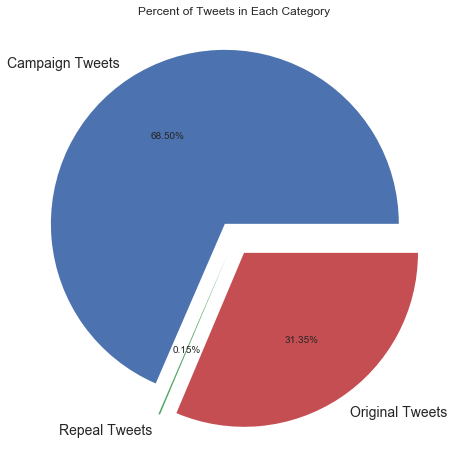

In [385]:
# For my final dataset, what was the breakdown between these three categories?

total_tweets = campaign_tweets_df['fullname'].count() + repeal_tweets_df['fullname'].count() + original_tweets_df['fullname'].count()
percentages = [str(campaign_tweets_df['fullname'].count()/total_tweets), str(repeal_tweets_df['fullname'].count()/total_tweets), \
         str(original_tweets_df['fullname'].count()/total_tweets)]

plt.subplots(figsize=(8,8))
plt.axes(aspect='equal')
plt.pie([campaign_tweets_df['fullname'].count(), repeal_tweets_df['fullname'].count(), \
         original_tweets_df['fullname'].count()], explode=[.1, .1 , .1], \
        labels=['Campaign Tweets', 'Repeal Tweets', 'Original Tweets'], autopct='%3.2f%%')
plt.title('Percent of Tweets in Each Category')
plt.show()

In [389]:
# Remove outliers from the retweet counts to get an idea what the distribution looked like.

retweets_outliers_rmv = eda.remove_outliers(mega_df, 'retweets')

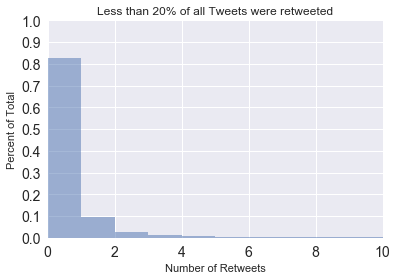

In [390]:
ticks = np.linspace(0,1, 11)

plt.hist(retweets_outliers_rmv, alpha=.5, bins = retweets_outliers_rmv.max(), normed=True)
plt.xlabel('Number of Retweets')
plt.ylabel('Percent of Total')
plt.yticks(ticks)
plt.title('Less than 20% of all Tweets were retweeted')
plt.xlim(0,10)
plt.show()

In [391]:
# Remove outliers from the like counts to get an idea what the distribution looked like.

likes_outliers_rmv = eda.remove_outliers(mega_df, 'likes')

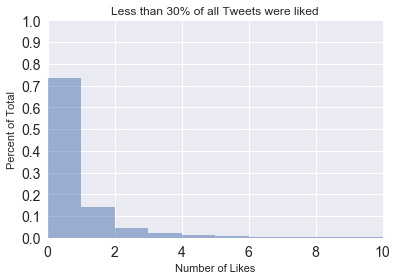

In [392]:
ticks = np.linspace(0,1, 11)

plt.hist(likes_outliers_rmv, alpha=.5, bins = likes_outliers_rmv.max(), normed=True)
plt.xlabel('Number of Likes')
plt.ylabel('Percent of Total')
plt.yticks(ticks)
plt.title('Less than 30% of all Tweets were liked')
plt.xlim(0,10)
plt.show()

In [393]:
# Remove outliers from the reply counts to get an idea what the distribution looked like.

replies_outliers_rmv = eda.remove_outliers(mega_df, 'replies')

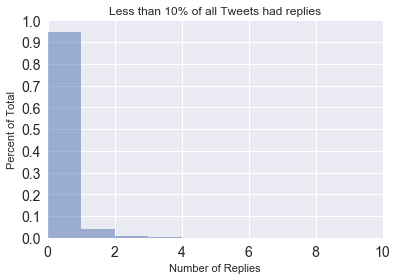

In [394]:
ticks = np.linspace(0,1, 11)

plt.hist(replies_outliers_rmv, bins = replies_outliers_rmv.max(), alpha=.5, normed=True)
plt.xlabel('Number of Replies')
plt.ylabel('Percent of Total')
plt.yticks(ticks)
plt.title('Less than 10% of all Tweets had replies')
plt.xlim(0,10)
plt.show()

## Time to compare the different categories

In [398]:
# Outliers removed like above, but only from the original tweet subset.

orig_retweets_outliers_rmv = eda.remove_outliers(original_tweets_df, 'retweets')

orig_likes_outliers_rmv = eda.remove_outliers(original_tweets_df, 'likes')

orig_replies_outliers_rmv = eda.remove_outliers(original_tweets_df, 'replies')

In [399]:
# Outliers removed like above, but only from the campaign tweet subset.

campaign_retweets_outliers_rmv = eda.remove_outliers(campaign_tweets_df, 'retweets')

campaign_likes_outliers_rmv = eda.remove_outliers(campaign_tweets_df, 'likes')

campaign_replies_outliers_rmv = eda.remove_outliers(campaign_tweets_df, 'replies')

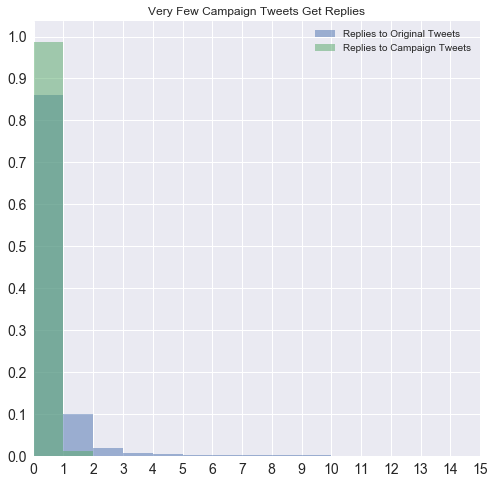

Original Tweets With Replies: 13.825974654935834%
Campaign Tweets With Replies: 1.2050949021460013%


In [428]:
# Lets see how the counts of original vs campaign tweet replies compare.

ticks = np.linspace(0,1, 11)
xticks = np.arange(16) 
bins_x = orig_replies_outliers_rmv.max()
bins_y = campaign_replies_outliers_rmv.max()

x = orig_replies_outliers_rmv
y = campaign_replies_outliers_rmv

plt.subplots(figsize=(8,8))
plt.hist(x, alpha=0.5, bins=bins_x, label='Replies to Original Tweets', normed=1)
plt.hist(y, alpha=0.5, bins=bins_y, label='Replies to Campaign Tweets', normed=1)
plt.yticks(ticks)
plt.xticks(xticks)
plt.xlim(0, 15)
plt.legend(loc='upper right')
plt.title('Very Few Campaign Tweets Get Replies')
plt.show()

print('Original Tweets With Replies: {}%'.format(100 - (100 * (orig_replies_outliers_rmv[orig_replies_outliers_rmv == 0].count() \
                                                  / orig_replies_outliers_rmv.count()))))
print('Campaign Tweets With Replies: {}%'.format(100 - (100 * (campaign_replies_outliers_rmv[campaign_replies_outliers_rmv == 0].count() \
                                                  / campaign_replies_outliers_rmv.count()))))

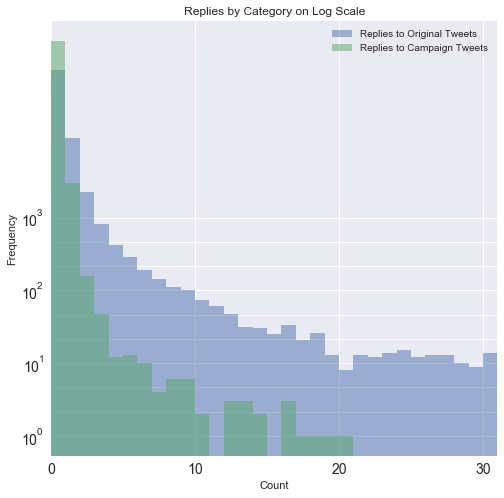

In [425]:
# Lets see how the counts of original vs campaign tweet replies compare.

ticks = np.logspace(0,3, 10)
xticks = np.arange(0, orig_replies_outliers_rmv.max(), 10) 
bins_x = orig_replies_outliers_rmv.max()
bins_y = campaign_replies_outliers_rmv.max()

x = orig_replies_outliers_rmv
y = campaign_replies_outliers_rmv

plt.subplots(figsize=(8,8))
plt.hist(x, log='y', alpha=0.5, bins=bins_x, label='Replies to Original Tweets')
plt.hist(y, log='y', alpha=0.5, bins=bins_y, label='Replies to Campaign Tweets')
plt.yticks(ticks)
plt.xticks(xticks)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.xlim(0, orig_replies_outliers_rmv.max())
plt.legend(loc='upper right')
plt.title('Replies by Category on Log Scale')
plt.show()

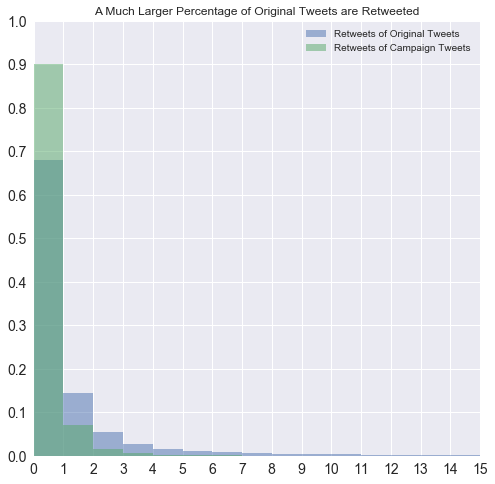

Original Tweets With Retweets: 31.92465139562863%
Campaign Tweets With Retweets: 9.997454053036876%


In [429]:
ticks = np.linspace(0,1, 11)
xticks = np.arange(16) 
bins_x = orig_retweets_outliers_rmv.max()
bins_y = campaign_retweets_outliers_rmv.max()

x = orig_retweets_outliers_rmv
y = campaign_retweets_outliers_rmv

plt.subplots(figsize=(8,8))
plt.hist(x, alpha=0.5, bins=bins_x, label='Retweets of Original Tweets', normed=1)
plt.hist(y, alpha=0.5, bins=bins_y, label='Retweets of Campaign Tweets', normed=1)
plt.yticks(ticks)
plt.xticks(xticks)
plt.xlim(0, 15)
plt.legend(loc='upper right')
plt.title('A Much Larger Percentage of Original Tweets are Retweeted')
plt.show()

print('Original Tweets With Retweets: {}%'.format(100 - (100 * (orig_retweets_outliers_rmv[orig_retweets_outliers_rmv == 0].count() \
                                                  / orig_retweets_outliers_rmv.count()))))
print('Campaign Tweets With Retweets: {}%'.format(100 - (100 * (campaign_retweets_outliers_rmv[campaign_retweets_outliers_rmv == 0].count() \
                                                  / campaign_retweets_outliers_rmv.count()))))

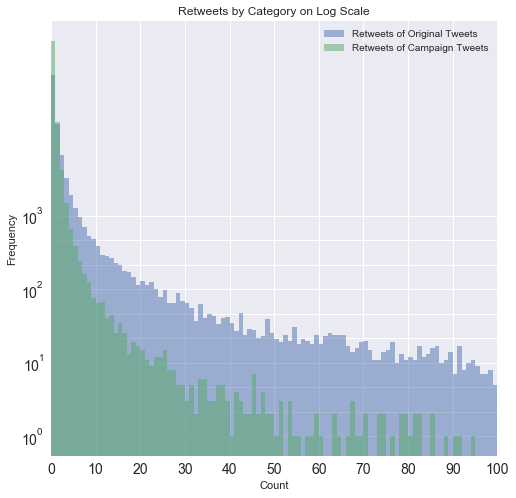

In [434]:
ticks = np.logspace(0,3, 10)
xticks = np.arange(0, 101, 10) 
bins_x = orig_retweets_outliers_rmv.max()
bins_y = campaign_retweets_outliers_rmv.max()

x = orig_retweets_outliers_rmv
y = campaign_retweets_outliers_rmv

plt.subplots(figsize=(8,8))
plt.hist(x, log='y', alpha=0.5, bins=bins_x, label='Retweets of Original Tweets')
plt.hist(y, log='y', alpha=0.5, bins=bins_y, label='Retweets of Campaign Tweets')
plt.yticks(ticks)
plt.xticks(xticks)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.legend(loc='upper right')
plt.title('Retweets by Category on Log Scale')
plt.show()

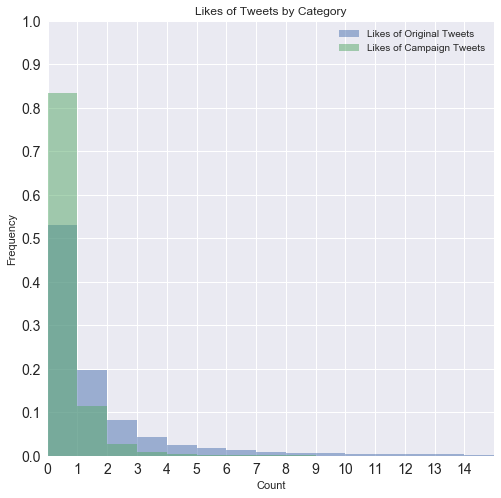

Original Tweets With Likes: 46.825614618476486%
Campaign Tweets With Likes: 16.48556005298522%


In [444]:
ticks = np.linspace(0,1, 11)
xticks = np.arange(15) 
bins_x = orig_likes_outliers_rmv.max()
bins_y = campaign_likes_outliers_rmv.max()

x = orig_likes_outliers_rmv
y = campaign_likes_outliers_rmv

plt.subplots(figsize=(8,8))
plt.hist(x, alpha=0.5, bins=bins_x, label='Likes of Original Tweets', normed=1)
plt.hist(y, alpha=0.5, bins=bins_y, label='Likes of Campaign Tweets', normed=1)
plt.yticks(ticks)
plt.xticks(xticks)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.xlim(0, 15)
plt.legend(loc='upper right')
plt.title('Likes of Tweets by Category')
plt.show()

print('Original Tweets With Likes: {}%'.format(100 - (100 * (orig_likes_outliers_rmv[orig_likes_outliers_rmv == 0].count() \
                                                  / orig_likes_outliers_rmv.count()))))
print('Campaign Tweets With Likes: {}%'.format(100 - (100 * (campaign_likes_outliers_rmv[campaign_likes_outliers_rmv == 0].count() \
                                                  / campaign_likes_outliers_rmv.count()))))

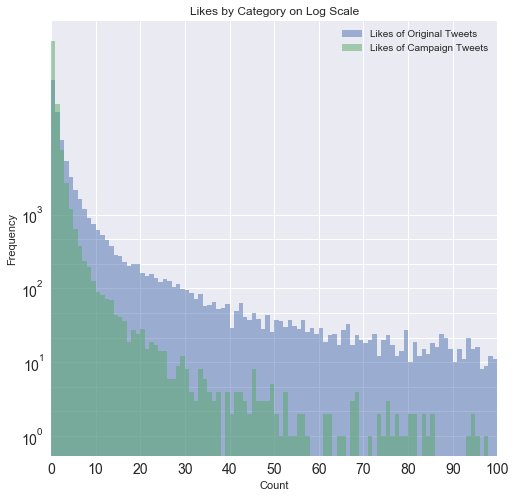

In [447]:
ticks = np.logspace(0,3, 10)
xticks = np.arange(0, 101, 10) 
bins_x = orig_likes_outliers_rmv.max()
bins_y = campaign_likes_outliers_rmv.max()

x = orig_likes_outliers_rmv
y = campaign_likes_outliers_rmv

plt.subplots(figsize=(8,8))
plt.hist(x, log='y', alpha=0.5, bins=bins_x, label='Likes of Original Tweets')
plt.hist(y, log='y', alpha=0.5, bins=bins_y, label='Likes of Campaign Tweets')
plt.yticks(ticks)
plt.xticks(xticks)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.legend(loc='upper right')
plt.title('Likes by Category on Log Scale')
plt.show()

### I hypothesize that people can tell what is real and what is a campaign and they are much more likely to engage in organic conversations by replying, liking, and retweeting.

### There is valuable insight to be drawn from this. As a business, your goal in a social media campaign may be to increase awareness of your brand or product. In this case, an information campaign may be a good idea since the volume of tweets can get much higher and more people will see it. If you are hoping to start a conversation or call to action, engaging influential individuals and having them spread your message is more effective.

## For each day recorded, what percent of tweets were original vs campaign?

In [451]:
# Create a dataframe indexed by date, leaving out 12/14 since the data collected for that day was not complete.
# Sum the counts of all integer fields by day.

mega_df_by_date = mega_df_final[mega_df_final['timestamp'] < '2017-12-14 00:00:00'].set_index("timestamp")
mega_df_by_date = mega_df_by_date.resample("D").sum()

In [453]:
# Create a list of dates just by month-day since they are all the same year.

month =  mega_df_by_date.index.month
day =  mega_df_by_date.index.day
date_list = []
for x in zip(mega_df_by_date.index.month, mega_df_by_date.index.day):
    date_list.append('{}-{}'.format(x[0], x[1]))

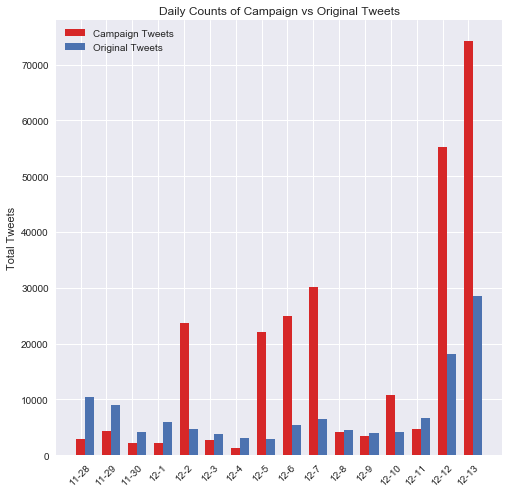

In [455]:
# Plot a paired bar chart of the daily counts of original tweets and campaign tweets

N = len(mega_df_by_date.index)
campaigns = mega_df_by_date['info_campaign']
originals = mega_df_by_date['original_tweet']
ind = np.arange(N)
width = 0.35

plt.subplots(figsize=(8,8))

p1 = plt.bar(ind, campaigns, width, color='#d62728')
p2 = plt.bar(ind + width, originals, width)

plt.ylabel('Total Tweets')
plt.title('Daily Counts of Campaign vs Original Tweets')
plt.xticks(ind, (date_list), rotation=45)
plt.rc('xtick') 
plt.rc('ytick') 
plt.legend((p1[0], p2[0]), ('Campaign Tweets', 'Original Tweets'))

plt.show()

### 12-2 and 12-10 are a Saturday and a Sunday.  12-5 to 12-7 were Tu-Th, and the increase in campaign tweets seems to occur again a week later. I suspect that with guided information campaigns, people were most likely to participate when they were taking a break at work or it was the weekend. The middle of the week is a time when a lot of people are likely to take a break from their job to check Twitter, and people do so on the weekend too. During a political debate, people may not have an opinion of their own they want to voice - however, it's very easy to see something you agree with when you're killing time by looking at Twitter and click a button to "participate" in a political conversation.

## Time to start doing some NLP

In [ ]:
# Load SpaCy's medium sized English language model.

nlp = spacy.load('en_core_web_md')

In [ ]:
mega_df_1 = mega_df[:50000]
mega_df_2 = mega_df[50000:100000]
mega_df_3 = mega_df[100000:150000]
mega_df_4 = mega_df[150000:200000]
mega_df_5 = mega_df[200000:250000]
mega_df_6 = mega_df[250000:300000]
mega_df_7 = mega_df[300000:350000]
mega_df_8 = mega_df[350000:400000]
mega_df_9 = mega_df[400000:]

slice_list = [mega_df_1, mega_df_2, mega_df_3, mega_df_4, mega_df_5, mega_df_6, mega_df_7, mega_df_8, mega_df_9]

In [ ]:
# Warning: this cell takes a VERY long time to run. I recommend that you simply import the DataFrame in the cell below.
# This will return a DataFrame with a column that shows all lemmatized adjectives from each tweet. Feel free to 
# review the code in EDA.py to see how the lemmatization works.

# mega_df_1 = eda.get_adj_lemmas(mega_df_1)
# mega_df_2 = eda.get_adj_lemmas(mega_df_2)
# mega_df_3 = eda.get_adj_lemmas(mega_df_3)
# mega_df_4 = eda.get_adj_lemmas(mega_df_4)
# mega_df_5 = eda.get_adj_lemmas(mega_df_5)
# mega_df_6 = eda.get_adj_lemmas(mega_df_6)
# mega_df_7 = eda.get_adj_lemmas(mega_df_7)
# mega_df_8 = eda.get_adj_lemmas(mega_df_8)
# mega_df_9 = eda.get_adj_lemmas(mega_df_9)

# mega_df_final = pd.concat([mega_df_1, mega_df_2, mega_df_3, mega_df_4, mega_df_5, mega_df_6, mega_df_7, mega_df_8, \
#                           mega_df_9], ignore_index=True)

# mega_df_final.to_json('./mega_df_final.json')

In [460]:
# Read in the data from the completed functions above as a DataFrame.

with zipfile.ZipFile("mega_df_final.zip", "r") as zip_ref:
    zip_ref.extractall("mega_df_final/")
mega_df_final = pd.read_json('mega_df_final/mega_df_final.json')
mega_df_final = mega_df_final.sort_index(axis=0)

## Let's look at the adjectives that people were using

In [463]:
# Updated versions of the campaign and original tweet DataFrames. update_campaign_tweets_df drops duplicate text
# because we will want to take a look at the most common words that showed up across each unique information campaign
# tweet, not just those that showed up a lot by volume.

update_campaign_tweets_df = mega_df_final[mega_df_final['info_campaign'] == 1].drop_duplicates(subset='text')
update_original_tweets_df = mega_df_final[mega_df_final['original_tweet'] == 1]

In [466]:
# Create a counter dictionary for adjectives in the original tweets. Ignore list was created by reviewing the results
# and removing words that were mistakenly tagged as adjectives.

original_adj_counter = Counter()
ignore_list = ['net', 'that', 'more', 'many', 'able', 'much', 'which', '“']

for adjs in update_original_tweets_df['adj_lemmas']:
    if (len(adjs) != 0):
        for adj in adjs:
            if adj not in ignore_list:
                original_adj_counter[adj] += 1

In [467]:
# Create a counter dictionary for adjectives in the campaign tweets. Ignore list was created by reviewing the results
# and removing words that were mistakenly tagged as adjectives.

campaign_adj_counter = Counter()
ignore_list = ['net', 'that', 'more', 'many', 'able', 'much', 'which', 'fccs', 'monthsnapchat', 'powerfulinternetproviderslike', 'thiscontact']

for adjs in update_campaign_tweets_df['adj_lemmas']:
    if (len(adj) != 0):
        for adj in adjs:
            if adj not in ignore_list:
                campaign_adj_counter[adj] += 1

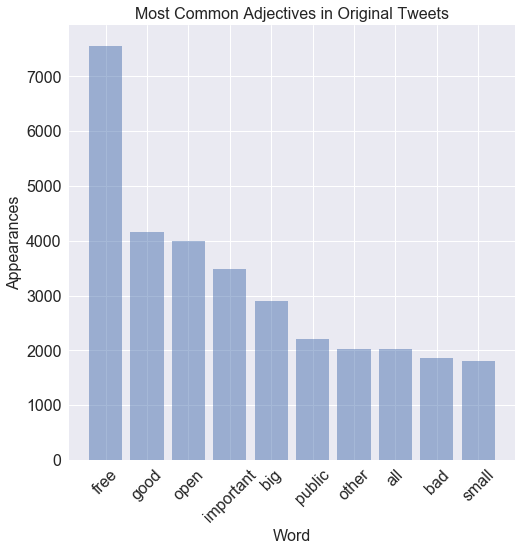

In [478]:
# Create a bar chart showing the number of appearances of the ten most common adjectives in original tweets.

counts = dict(original_adj_counter.most_common(10))

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.subplots(figsize=(8,8))
plt.bar(indexes, values, alpha=.5)
plt.xticks(rotation=45)

# add labels
plt.xticks(indexes, labels, rotation=45)
plt.title('Most Common Adjectives in Original Tweets', fontsize=16)
plt.ylabel('Appearances', fontsize=16)
plt.xlabel('Word', fontsize=16)
plt.show()

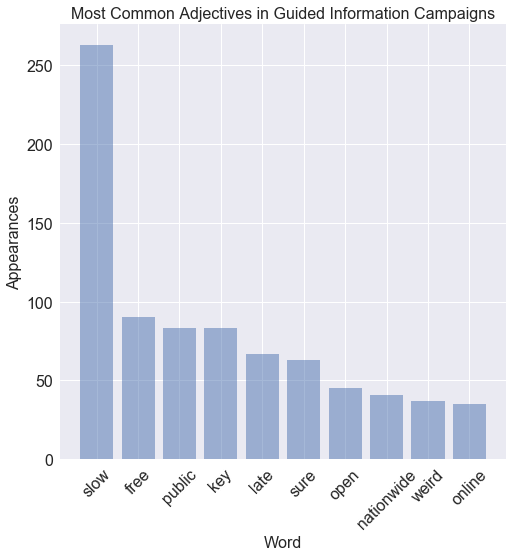

In [477]:
# Create a bar chart showing the number of appearances of the ten most common adjectives in guided information 
# campaigns.

counts = dict(campaign_adj_counter.most_common(10))

labels, values = zip(*counts.items())

# Sort values in descending order
indSort = np.argsort(values)[::-1]

# Rearrange data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.subplots(figsize=(8,8))
plt.bar(indexes, values, alpha=.5)
plt.xticks(indexes, labels, rotation=45)
plt.title('Most Common Adjectives in Guided Information Campaigns', fontsize=16)
plt.ylabel('Appearances', fontsize=16)
plt.xlabel('Word', fontsize=16)
plt.show()

# Network Graphing & Community Detection

### Now that the NLP is complete and we have classified the tweets and identified the distinct opinion language used by both categories of Tweeters, it's time to use graph theory to detect some networks. I chose to do this by creating edges based on who was mentioned together in tweets. This will allow us to see what communities are being formed through association - who do Twitter users see as being connected to each other?

In [484]:
# First, create a list of every 2-item combo of mentions found in tweets in the data.

flat_list = eda.combos_of_ats(mega_df_final)

# Arrange these into an array where the two mentions are arranged in alphabetical order.

alpha_array = eda.alpha_tuples(flat_list)

# Put this into a dataframe where the first item in every pair is in column 'source' and the second item is in column
# 'target' (this will be helpful when creating a graph in a few steps). Create a column 'count' that has a count of 
# every time each pair showed up in the data.

grouped_source_target_df = eda.create_grouped_source_target(alpha_array)

In [486]:
# Restrict this to only pairs that showed up 10 times or more. The graph won't be interpretable otherwise, and this is
# a good threshold for determining whether or not accounts were mentioned together frequently enough to matter.

grouped_source_target_df = grouped_source_target_df[grouped_source_target_df['count'] > 9]

In [487]:
# Create an index of all the unique mentions in the data.

unique_ats = pd.Index(grouped_source_target_df['source'].append(grouped_source_target_df['target'])
                      .reset_index(drop=True).unique())

In [488]:
# Create a list of every edge - a connection indicating that two users were mentioned together 10+ times.

links_list = eda.create_links_list(grouped_source_target_df, unique_ats)

# Create a list of every node - these represent every user who was mentioned in the data.

nodes_list = eda.create_nodes_list(unique_ats)

In [489]:
# Create a NetworkX graph object so I can do some community detection

G = nx.Graph()

# Add nodes to the graph

for node in nodes_list:
    G.add_node(node['index'], name=node['name'])

# Add edges to the graph

for link in links_list:
    G.add_edge(link['source'], link['target'], weight=link['value'])

In [491]:
# Create optimized communities using Louvain modularity

communities = community.best_partition(G, partition=None, weight='weight', resolution=1.0, randomize=False)

In [494]:
# Add community labels to the nodes

for idx, group in enumerate(communities.values()):
    nodes_list[idx]['group'] = group

In [ ]:
# Preparing the node and edge lists to be exported as json. These files already exist, so there is no need to run
# this code.

# json_prep = {"nodes":nodes_list, "links":links_list}
# json_dump = json.dumps(json_prep, indent=1, sort_keys=True)

# filename_out = 'app/static/nodes_edges.json'
# json_out = open(filename_out,'w')
# json_out.write(json_dump)
# json_out.close()

In [ ]:
bc_dict = nx.betweenness_centrality(G, weight='weight')
sorted_bc_tups = sorted(bc_dict.items(), key=operator.itemgetter(1), reverse=True)

### Remove highest betweened node and redo the graph to see if other communities come up

In [ ]:
# Create a list of every 2-item combo of mentions found in tweets in the data that DO NOT include the node with
# highest betweenness centrality ('@ajitpaifcc').

flat_list_one_removed = []

for item in flat_list:
    if nodes_list[sorted_bc_tups[0][0]]['name'] not in item:
        flat_list_one_removed.append(item)

In [ ]:
# Arrange these into an array where the two mentions are arranged in alphabetical order.
alpha_array_one_removed = eda.alpha_tuples(flat_list_one_removed)

# Put this into a dataframe where the first item in every pair is in column 'source' and the second item is in column
# 'target'. Create a column 'count' that has a count of every time each pair showed up in the data.
grouped_source_target_df_one_removed = eda.create_grouped_source_target(alpha_array_one_removed)

In [ ]:
grouped_source_target_df_one_removed = grouped_source_target_df_one_removed[grouped_source_target_df_one_removed['count'] > 8]

In [ ]:
# Create an index of all the unique mentions in the data.
unique_ats_one_removed = pd.Index(grouped_source_target_df_one_removed['source']
                      .append(grouped_source_target_df_one_removed['target'])
                      .reset_index(drop=True).unique())

In [ ]:
# Create a list of every edge - a time that two accounts were mentioned in the same tweet.
links_list_one_removed = eda.create_links_list(grouped_source_target_df_one_removed, unique_ats_one_removed)

# Create a list of every node
nodes_list_one_removed = eda.create_nodes_list(unique_ats_one_removed)

In [ ]:
G_one_removed = nx.Graph()

In [ ]:
for node in nodes_list_one_removed:
    G_one_removed.add_node(node['index'], name=node['name'])

In [ ]:
for link in links_list_one_removed:
    G_one_removed.add_edge(link['source'], link['target'], weight=link['value'])

In [ ]:
communities_one_removed = community.best_partition(G_one_removed, partition=None, weight='weight', resolution=1.0, randomize=False)

In [ ]:
for idx, group in enumerate(communities_one_removed.values()):
    nodes_list_one_removed[idx]['group'] = group

In [ ]:
json_prep_removed = {"nodes":nodes_list_one_removed, "links":links_list_one_removed}
json_dump_removed = json.dumps(json_prep_removed, indent=1, sort_keys=True)

filename_out = 'app/static/nodes_edges_one_removed.json'
json_out = open(filename_out,'w')
json_out.write(json_dump_removed)
json_out.close()

### Remove second highest betweened node and redo the graph to see if other communities come up

In [ ]:
# Create a list of every 2-item combo of mentions found in tweets in the data that DO NOT include the two nodes with
# highest betweenness centrality ('@ajitpaifcc').

flat_list_two_removed = []

for item in flat_list:
    if (nodes_list[sorted_bc_tups[0][0]]['name'] not in item) & (nodes_list[sorted_bc_tups[1][0]]['name'] not in item):
        flat_list_two_removed.append(item)

In [ ]:
# Arrange these into an array where the two mentions are arranged in alphabetical order.
alpha_array_two_removed = eda.alpha_tuples(flat_list_two_removed)

# Put this into a dataframe where the first item in every pair is in column 'source' and the second item is in column
# 'target'. Create a column 'count' that has a count of every time each pair showed up in the data.
grouped_source_target_df_two_removed = eda.create_grouped_source_target(alpha_array_two_removed)

In [ ]:
grouped_source_target_df_two_removed = grouped_source_target_df_two_removed[grouped_source_target_df_two_removed['count'] > 8]

In [ ]:
# Create an index of all the unique mentions in the data.
unique_ats_two_removed = pd.Index(grouped_source_target_df_two_removed['source']
                      .append(grouped_source_target_df_two_removed['target'])
                      .reset_index(drop=True).unique())

In [ ]:
# Create a list of every edge - a time that two accounts were mentioned in the same tweet.
links_list_two_removed = eda.create_links_list(grouped_source_target_df_two_removed, unique_ats_two_removed)

# Create a list of every node
nodes_list_two_removed = eda.create_nodes_list(unique_ats_two_removed)

In [ ]:
G_two_removed = nx.Graph()

In [ ]:
for node in nodes_list_two_removed:
    G_two_removed.add_node(node['index'], name=node['name'])

In [ ]:
for link in links_list_two_removed:
    G_two_removed.add_edge(link['source'], link['target'], weight=link['value'])

In [ ]:
communities_two_removed = community.best_partition(G_two_removed, partition=None, weight='weight', resolution=1.0, randomize=False)

In [ ]:
for idx, group in enumerate(communities_two_removed.values()):
    nodes_list_two_removed[idx]['group'] = group

In [ ]:
json_prep_2_removed = {"nodes":nodes_list_two_removed, "links":links_list_two_removed}
json_dump_2_removed = json.dumps(json_prep_2_removed, indent=1, sort_keys=True)

filename_out = 'app/static/nodes_edges_two_removed.json'
json_out = open(filename_out,'w')
json_out.write(json_dump_2_removed)
json_out.close()

Pick a time window (12 hours is probably good) and determine the probabilities on a gamma distro of each user showing up over that period (will need to use Bayesian modeling to update priors). Set a threshold above which I will consider something to be showing up more than expected. When this happens, look at the communities that are being detected.

In [3]:
# Create an array of all unique users that are mentioned in tweets.

mentioned_set = set()

for item in mega_df_final['@s']:
    for name in item:
        mentioned_set.add(name)
        

In [4]:
at_table_list_of_lists = []

for idx, item in enumerate(mega_df_final['@s']):
    for at in item:
        at_table_list_of_lists.append([at, mega_df_final.iloc[idx]['timestamp']])

In [5]:
headers = ['users', 'timestamp']
at_df = pd.DataFrame(at_table_list_of_lists, columns=headers)

In [34]:
from datetime import date, datetime, timedelta

def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta
        
time_ranges = []        
for result in perdelta(datetime(2017, 11, 28, 12, 0, 0), datetime(2017, 12, 15, 12, 0, 0), timedelta(hours=12)):
     time_ranges.append(result)

In [43]:
# for idx, time in enumerate(at_df['timestamp'][:10]):
#     if time < time_ranges[1]:
#         at_df['end_ts'] = time_ranges[1]

slice_1_ats = at_df[at_df['timestamp'] < time_ranges[0]]
slice_2_ats = at_df[(at_df['timestamp'] >= time_ranges[0]) & (at_df['timestamp'] < time_ranges[1])]
slice_3_ats = at_df[(at_df['timestamp'] >= time_ranges[1]) & (at_df['timestamp'] < time_ranges[2])]
slice_4_ats = at_df[(at_df['timestamp'] >= time_ranges[2]) & (at_df['timestamp'] < time_ranges[3])]
slice_5_ats = at_df[(at_df['timestamp'] >= time_ranges[3]) & (at_df['timestamp'] < time_ranges[4])]
slice_6_ats = at_df[(at_df['timestamp'] >= time_ranges[4]) & (at_df['timestamp'] < time_ranges[5])]
slice_7_ats = at_df[(at_df['timestamp'] >= time_ranges[5]) & (at_df['timestamp'] < time_ranges[6])]
slice_8_ats = at_df[(at_df['timestamp'] >= time_ranges[6]) & (at_df['timestamp'] < time_ranges[7])]
slice_9_ats = at_df[(at_df['timestamp'] >= time_ranges[7]) & (at_df['timestamp'] < time_ranges[8])]
slice_10_ats = at_df[(at_df['timestamp'] >= time_ranges[8]) & (at_df['timestamp'] < time_ranges[9])]
slice_11_ats = at_df[(at_df['timestamp'] >= time_ranges[9]) & (at_df['timestamp'] < time_ranges[10])]
slice_12_ats = at_df[(at_df['timestamp'] >= time_ranges[10]) & (at_df['timestamp'] < time_ranges[11])]
slice_13_ats = at_df[(at_df['timestamp'] >= time_ranges[11]) & (at_df['timestamp'] < time_ranges[12])]
slice_14_ats = at_df[(at_df['timestamp'] >= time_ranges[12]) & (at_df['timestamp'] < time_ranges[13])]
slice_15_ats = at_df[(at_df['timestamp'] >= time_ranges[13]) & (at_df['timestamp'] < time_ranges[14])]
slice_16_ats = at_df[(at_df['timestamp'] >= time_ranges[14]) & (at_df['timestamp'] < time_ranges[15])]
slice_17_ats = at_df[(at_df['timestamp'] >= time_ranges[15]) & (at_df['timestamp'] < time_ranges[16])]
slice_18_ats = at_df[(at_df['timestamp'] >= time_ranges[16]) & (at_df['timestamp'] < time_ranges[17])]
slice_19_ats = at_df[(at_df['timestamp'] >= time_ranges[17]) & (at_df['timestamp'] < time_ranges[18])]
slice_20_ats = at_df[(at_df['timestamp'] >= time_ranges[18]) & (at_df['timestamp'] < time_ranges[19])]
slice_21_ats = at_df[(at_df['timestamp'] >= time_ranges[19]) & (at_df['timestamp'] < time_ranges[20])]
slice_22_ats = at_df[(at_df['timestamp'] >= time_ranges[20]) & (at_df['timestamp'] < time_ranges[21])]
slice_23_ats = at_df[(at_df['timestamp'] >= time_ranges[21]) & (at_df['timestamp'] < time_ranges[22])]
slice_24_ats = at_df[(at_df['timestamp'] >= time_ranges[22]) & (at_df['timestamp'] < time_ranges[23])]
slice_25_ats = at_df[(at_df['timestamp'] >= time_ranges[23]) & (at_df['timestamp'] < time_ranges[24])]
slice_26_ats = at_df[(at_df['timestamp'] >= time_ranges[24]) & (at_df['timestamp'] < time_ranges[25])]
slice_27_ats = at_df[(at_df['timestamp'] >= time_ranges[25]) & (at_df['timestamp'] < time_ranges[26])]
slice_28_ats = at_df[(at_df['timestamp'] >= time_ranges[26]) & (at_df['timestamp'] < time_ranges[27])]
slice_29_ats = at_df[(at_df['timestamp'] >= time_ranges[27]) & (at_df['timestamp'] < time_ranges[28])]
slice_30_ats = at_df[(at_df['timestamp'] >= time_ranges[28]) & (at_df['timestamp'] < time_ranges[29])]
slice_31_ats = at_df[(at_df['timestamp'] >= time_ranges[29]) & (at_df['timestamp'] < time_ranges[30])]
slice_32_ats = at_df[(at_df['timestamp'] >= time_ranges[30]) & (at_df['timestamp'] < time_ranges[31])]
slice_33_ats = at_df[(at_df['timestamp'] >= time_ranges[31]) & (at_df['timestamp'] < time_ranges[32])]
slice_34_ats = at_df[(at_df['timestamp'] >= time_ranges[32]) & (at_df['timestamp'] < time_ranges[33])]

In [69]:
time_ranges[33]

datetime.datetime(2017, 12, 15, 0, 0)

In [70]:
slice_1_ats['end_ts'] = time_ranges[0]
slice_2_ats['end_ts'] = time_ranges[1]
slice_3_ats['end_ts'] = time_ranges[2]
slice_4_ats['end_ts'] = time_ranges[3]
slice_5_ats['end_ts'] = time_ranges[4]
slice_6_ats['end_ts'] = time_ranges[5]
slice_7_ats['end_ts'] = time_ranges[6]
slice_8_ats['end_ts'] = time_ranges[7]
slice_9_ats['end_ts'] = time_ranges[8]
slice_10_ats['end_ts'] = time_ranges[9]
slice_11_ats['end_ts'] = time_ranges[10]
slice_12_ats['end_ts'] = time_ranges[11]
slice_13_ats['end_ts'] = time_ranges[12]
slice_14_ats['end_ts'] = time_ranges[13]
slice_15_ats['end_ts'] = time_ranges[14]
slice_16_ats['end_ts'] = time_ranges[15]
slice_17_ats['end_ts'] = time_ranges[16]
slice_18_ats['end_ts'] = time_ranges[17]
slice_19_ats['end_ts'] = time_ranges[18]
slice_20_ats['end_ts'] = time_ranges[19]
slice_21_ats['end_ts'] = time_ranges[20]
slice_22_ats['end_ts'] = time_ranges[21]
slice_23_ats['end_ts'] = time_ranges[22]
slice_24_ats['end_ts'] = time_ranges[23]
slice_25_ats['end_ts'] = time_ranges[24]
slice_26_ats['end_ts'] = time_ranges[25]
slice_27_ats['end_ts'] = time_ranges[26]
slice_28_ats['end_ts'] = time_ranges[27]
slice_29_ats['end_ts'] = time_ranges[28]
slice_30_ats['end_ts'] = time_ranges[29]
slice_31_ats['end_ts'] = time_ranges[30]
slice_32_ats['end_ts'] = time_ranges[31]
slice_33_ats['end_ts'] = time_ranges[32]
slice_34_ats['end_ts'] = time_ranges[33]

/Users/Katie/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Katie/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Katie/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/Users/Katie/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Katie/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Katie/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

In [73]:
grouped_at_df = pd.concat([slice_1_ats, slice_2_ats, slice_3_ats, slice_4_ats, slice_5_ats, slice_6_ats, slice_7_ats,\
                          slice_8_ats, slice_9_ats, slice_10_ats, slice_11_ats, slice_12_ats, slice_13_ats, slice_14_ats,\
                          slice_15_ats, slice_16_ats, slice_17_ats, slice_18_ats, slice_19_ats, slice_20_ats, slice_21_ats,\
                          slice_22_ats, slice_23_ats, slice_24_ats, slice_25_ats, slice_26_ats, slice_27_ats, slice_28_ats,\
                          slice_29_ats, slice_30_ats, slice_31_ats, slice_32_ats, slice_33_ats, slice_34_ats])

In [76]:
grouped_at_df['end_ts'].unique()



array(['2017-11-28T12:00:00.000000000', '2017-11-29T00:00:00.000000000',
       '2017-11-29T12:00:00.000000000', '2017-11-30T00:00:00.000000000',
       '2017-11-30T12:00:00.000000000', '2017-12-01T00:00:00.000000000',
       '2017-12-01T12:00:00.000000000', '2017-12-02T00:00:00.000000000',
       '2017-12-02T12:00:00.000000000', '2017-12-03T00:00:00.000000000',
       '2017-12-03T12:00:00.000000000', '2017-12-04T00:00:00.000000000',
       '2017-12-04T12:00:00.000000000', '2017-12-05T00:00:00.000000000',
       '2017-12-06T00:00:00.000000000', '2017-12-06T12:00:00.000000000',
       '2017-12-07T00:00:00.000000000', '2017-12-07T12:00:00.000000000',
       '2017-12-08T00:00:00.000000000', '2017-12-08T12:00:00.000000000',
       '2017-12-09T00:00:00.000000000', '2017-12-09T12:00:00.000000000',
       '2017-12-10T00:00:00.000000000', '2017-12-10T12:00:00.000000000',
       '2017-12-11T00:00:00.000000000', '2017-12-11T12:00:00.000000000',
       '2017-12-12T00:00:00.000000000', '2017-12-12

In [82]:
grouped_at_df.groupby(['end_ts', 'users']).agg(['count'])

timestamp
                                         count
end_ts              users                     
2017-11-28 12:00:00 @4chan                   1
                    @7879881122              1
                    @7im                     1
                    @_cberger_               1
                    @abc                     2
                    @abpmajhatv              1
                    @ac360                   1
                    @aclu                    6
                    @adityakalra             1
                    @afrotribuneco           1
                    @aftunion                1
                    @agschneiderman          2
                    @airbnb                  1
                    @airtel_presence         7
                    @airtelindia             2
                    @aitcofficial            1
                    @ajiolife                1
                    @ajitpai                 2
                    @ajitpaifcc            376
                    @ajplus                  1
                    @aksharpathak            1
                    @akshaykumar             1
                    @alalibrary              1
                    @alysonstoner            1
                    @amandaseales            2
                    @amazon                  7
                    @ambertamblyn            1
                    @amchamhk                1
                    @amitshah                1
                    @amol_kulkarni1          1
...                                        ...
2017-12-15 00:00:00 @twittersafety           1
                    @txag                    3
                    @usasenate               1
                    @usbtsarmy               1
                    @usrealitycheck          1
                    @verge                   2
                    @verizon                20
                    @vh1                     1
                    @vicxoralt               1
                    @virginiafoxx            1
                    @vonage                  1
                    @votejakechapman         1
                    @washingtonpost          2
                    @wdtn                    1
                    @wdtnmarkallan           1
                    @wellsvillecsd           1
                    @whitehouse              3
                    @whoopigoldberg          1
                    @windows                 1
                    @wired                   1
                    @wsj                     1
                    @xataka                  1
                    @xfinity                 1
                    @xterra1_                1
                    @yahoo                   1
                    @youranoncentral         1
                    @youranonnews            1
                    @yourdnrec               1
                    @youtube                12
                    @zachhaller              1

[21898 rows x 1 columns]

In [ ]:
at_dataframe = pd.DataFrame(at_table_array, columns=['user','timestamp'])
grouped_at_df = at_dataframe.copy()

In [ ]:
grouped_at_df

In [ ]:
day_1_am_df = at_dataframe[(at_dataframe['timestamp'] > '2017-11-28 00:00:01') & (at_dataframe['timestamp'] < '2017-11-28 12:00:00')]
day_1_pm_df = mega_df_12h_slice.loc['2017-11-28 12:00:01':'2017-11-29 00:00:00']
day_2_am_df = mega_df_12h_slice.loc['2017-11-29 00:00:01':'2017-11-29 12:00:00']
day_2_pm_df = mega_df_12h_slice.loc['2017-11-29 12:00:01':'2017-11-30 00:00:00']
day_3_am_df = mega_df_12h_slice.loc['2017-11-30 00:00:01':'2017-11-30 12:00:00']
day_3_pm_df = mega_df_12h_slice.loc['2017-11-30 12:00:01':'2017-12-01 00:00:00']
day_4_am_df = mega_df_12h_slice.loc['2017-12-01 00:00:01':'2017-12-01 12:00:00']
day_4_pm_df = mega_df_12h_slice.loc['2017-12-01 12:00:01':'2017-12-02 00:00:00']
day_5_am_df = mega_df_12h_slice.loc['2017-12-02 00:00:01':'2017-12-02 12:00:00']
day_5_pm_df = mega_df_12h_slice.loc['2017-12-02 12:00:01':'2017-12-03 00:00:00']
day_6_am_df = mega_df_12h_slice.loc['2017-12-03 00:00:01':'2017-12-03 12:00:00']
day_6_pm_df = mega_df_12h_slice.loc['2017-12-03 12:00:01':'2017-12-04 00:00:00']
day_7_am_df = mega_df_12h_slice.loc['2017-12-04 00:00:01':'2017-12-04 12:00:00']
day_7_pm_df = mega_df_12h_slice.loc['2017-12-04 12:00:01':'2017-12-05 00:00:00']
day_8_am_df = mega_df_12h_slice.loc['2017-12-05 00:00:01':'2017-12-05 12:00:00']
day_8_pm_df = mega_df_12h_slice.loc['2017-12-05 12:00:01':'2017-12-06 00:00:00']
day_9_am_df = mega_df_12h_slice.loc['2017-12-06 00:00:01':'2017-12-06 12:00:00']
day_9_pm_df = mega_df_12h_slice.loc['2017-12-06 12:00:01':'2017-12-07 00:00:00']
day_10_am_df = mega_df_12h_slice.loc['2017-12-07 00:00:01':'2017-12-07 12:00:00']
day_10_pm_df = mega_df_12h_slice.loc['2017-12-07 12:00:01':'2017-12-08 00:00:00']
day_11_am_df = mega_df_12h_slice.loc['2017-12-08 00:00:01':'2017-12-08 12:00:00']
day_11_pm_df = mega_df_12h_slice.loc['2017-12-08 12:00:01':'2017-12-09 00:00:00']
day_12_am_df = mega_df_12h_slice.loc['2017-12-09 00:00:01':'2017-12-09 12:00:00']
day_12_pm_df = mega_df_12h_slice.loc['2017-12-09 12:00:01':'2017-12-10 00:00:00']
day_13_am_df = mega_df_12h_slice.loc['2017-12-10 00:00:01':'2017-12-10 12:00:00']
day_13_pm_df = mega_df_12h_slice.loc['2017-12-10 12:00:01':'2017-12-11 00:00:00']
day_14_am_df = mega_df_12h_slice.loc['2017-12-11 00:00:01':'2017-12-11 12:00:00']
day_14_pm_df = mega_df_12h_slice.loc['2017-12-11 12:00:01':'2017-12-12 00:00:00']
day_15_am_df = mega_df_12h_slice.loc['2017-12-12 00:00:01':'2017-12-12 12:00:00']
day_15_pm_df = mega_df_12h_slice.loc['2017-12-12 12:00:01':'2017-12-13 00:00:00']
day_16_am_df = mega_df_12h_slice.loc['2017-12-13 00:00:01':'2017-12-13 12:00:00']
day_16_pm_df = mega_df_12h_slice.loc['2017-12-13 12:00:01':'2017-12-14 00:00:00']
day_17_am_df = mega_df_12h_slice.loc['2017-12-14 00:00:01':'2017-12-14 12:00:00']
day_17_pm_df = mega_df_12h_slice.loc['2017-12-14 12:00:01':'2017-12-15 00:00:00']

In [ ]:
count_of_at_tweets = 0
for item in mega_df_final['@s']:
    if len(item) != 0:
        count_of_at_tweets += len(item)
        
count_of_at_tweets

In [ ]:
# Dataframe with each person who was mentioned and the timestamp that it happened (every single mention)

at_dataframe = pd.DataFrame(np.zeros((count_of_at_tweets, 2)), columns=['user', 'timestamp'])

In [ ]:
for idx, at in enumerate(mega_df_final['@s'][:20]):
    if len(at) != 0:
        for item in at:
            at_dataframe.iloc[i]['user'] = item
            at_dataframe.iloc[i]['timestamp'] = mega_df_final.iloc[idx]['timestamp']
            i += 1

In [ ]:
at_dataframe

In [ ]:
for idx, user in enumerate(at_dataframe['user']):
    at_dataframe.iloc[idx]['total_ats'] = Counter[user]
    at_dataframe.iloc[user]['timestamp'] = 

In [ ]:
mega_df_final

In [ ]:
## Slice the data up into 12 hour windows

In [ ]:
# Create a copy of the main dataframe. Figure out how many total days there are. Make the timestamp the index so these

mega_df_12h_slice = mega_df_final
num_days = len(mega_df_12h_slice['timestamp'].dt.day.unique())
mega_df_12h_slice = mega_df_12h_slice.set_index(['timestamp'])

In [ ]:
# ...but not too easily. Slice the dataframe into 12 hour windows manually.

day_1_am_df = mega_df_12h_slice.loc['2017-11-28 00:00:01':'2017-11-28 12:00:00']
day_1_pm_df = mega_df_12h_slice.loc['2017-11-28 12:00:01':'2017-11-29 00:00:00']
day_2_am_df = mega_df_12h_slice.loc['2017-11-29 00:00:01':'2017-11-29 12:00:00']
day_2_pm_df = mega_df_12h_slice.loc['2017-11-29 12:00:01':'2017-11-30 00:00:00']
day_3_am_df = mega_df_12h_slice.loc['2017-11-30 00:00:01':'2017-11-30 12:00:00']
day_3_pm_df = mega_df_12h_slice.loc['2017-11-30 12:00:01':'2017-12-01 00:00:00']
day_4_am_df = mega_df_12h_slice.loc['2017-12-01 00:00:01':'2017-12-01 12:00:00']
day_4_pm_df = mega_df_12h_slice.loc['2017-12-01 12:00:01':'2017-12-02 00:00:00']
day_5_am_df = mega_df_12h_slice.loc['2017-12-02 00:00:01':'2017-12-02 12:00:00']
day_5_pm_df = mega_df_12h_slice.loc['2017-12-02 12:00:01':'2017-12-03 00:00:00']
day_6_am_df = mega_df_12h_slice.loc['2017-12-03 00:00:01':'2017-12-03 12:00:00']
day_6_pm_df = mega_df_12h_slice.loc['2017-12-03 12:00:01':'2017-12-04 00:00:00']
day_7_am_df = mega_df_12h_slice.loc['2017-12-04 00:00:01':'2017-12-04 12:00:00']
day_7_pm_df = mega_df_12h_slice.loc['2017-12-04 12:00:01':'2017-12-05 00:00:00']
day_8_am_df = mega_df_12h_slice.loc['2017-12-05 00:00:01':'2017-12-05 12:00:00']
day_8_pm_df = mega_df_12h_slice.loc['2017-12-05 12:00:01':'2017-12-06 00:00:00']
day_9_am_df = mega_df_12h_slice.loc['2017-12-06 00:00:01':'2017-12-06 12:00:00']
day_9_pm_df = mega_df_12h_slice.loc['2017-12-06 12:00:01':'2017-12-07 00:00:00']
day_10_am_df = mega_df_12h_slice.loc['2017-12-07 00:00:01':'2017-12-07 12:00:00']
day_10_pm_df = mega_df_12h_slice.loc['2017-12-07 12:00:01':'2017-12-08 00:00:00']
day_11_am_df = mega_df_12h_slice.loc['2017-12-08 00:00:01':'2017-12-08 12:00:00']
day_11_pm_df = mega_df_12h_slice.loc['2017-12-08 12:00:01':'2017-12-09 00:00:00']
day_12_am_df = mega_df_12h_slice.loc['2017-12-09 00:00:01':'2017-12-09 12:00:00']
day_12_pm_df = mega_df_12h_slice.loc['2017-12-09 12:00:01':'2017-12-10 00:00:00']
day_13_am_df = mega_df_12h_slice.loc['2017-12-10 00:00:01':'2017-12-10 12:00:00']
day_13_pm_df = mega_df_12h_slice.loc['2017-12-10 12:00:01':'2017-12-11 00:00:00']
day_14_am_df = mega_df_12h_slice.loc['2017-12-11 00:00:01':'2017-12-11 12:00:00']
day_14_pm_df = mega_df_12h_slice.loc['2017-12-11 12:00:01':'2017-12-12 00:00:00']
day_15_am_df = mega_df_12h_slice.loc['2017-12-12 00:00:01':'2017-12-12 12:00:00']
day_15_pm_df = mega_df_12h_slice.loc['2017-12-12 12:00:01':'2017-12-13 00:00:00']
day_16_am_df = mega_df_12h_slice.loc['2017-12-13 00:00:01':'2017-12-13 12:00:00']
day_16_pm_df = mega_df_12h_slice.loc['2017-12-13 12:00:01':'2017-12-14 00:00:00']
day_17_am_df = mega_df_12h_slice.loc['2017-12-14 00:00:01':'2017-12-14 12:00:00']
day_17_pm_df = mega_df_12h_slice.loc['2017-12-14 12:00:01':'2017-12-15 00:00:00']

In [ ]:
# Confirming that this contains the same number of entries total as the original dataframe.

print(len(day_1_am_df['user']) + len(day_1_pm_df['user']) + len(day_2_am_df['user']) + len(day_2_pm_df['user']) \
+ len(day_3_am_df['user']) + len(day_3_pm_df['user']) + len(day_4_am_df['user']) + len(day_4_pm_df['user'])\
+ len(day_5_am_df['user']) + len(day_5_pm_df['user']) + len(day_6_am_df['user']) + len(day_6_pm_df['user'])\
+ len(day_7_am_df['user']) + len(day_7_pm_df['user']) + len(day_8_am_df['user']) + len(day_8_pm_df['user'])\
+ len(day_9_am_df['user']) + len(day_9_pm_df['user']) + len(day_10_am_df['user']) + len(day_10_pm_df['user'])\
+ len(day_11_am_df['user']) + len(day_11_pm_df['user']) + len(day_12_am_df['user']) + len(day_12_pm_df['user'])\
+ len(day_13_am_df['user']) + len(day_13_pm_df['user']) + len(day_14_am_df['user']) + len(day_14_pm_df['user'])\
+ len(day_15_am_df['user']) + len(day_15_pm_df['user']) + len(day_16_am_df['user']) + len(day_16_pm_df['user'])\
+ len(day_17_am_df['user']) + len(day_17_pm_df['user']))

print(len(mega_df_final['user']))

In [ ]:
# Create an array of all unique users that are mentioned in tweets.

mentioned_set = set()

for item in mega_df_final['@s']:
    for name in item:
        mentioned_set.add(name)
        
mentioned_array = np.array(list(mentioned_set))

In [ ]:
# Use the above array to create a dataframe of all unique users who are mentioned in tweets with a 'frequency' column
# to be filled in with the probability each user will be mentioned in any randomly selected tweet.

user_mention_freq_df = pd.DataFrame(mentioned_array, columns=['user'])
user_mention_freq_df['prob_of_appearing'] = pd.Series(np.zeros((len(mentioned_set), )))

In [ ]:
# Create a counter dictionary that tells us how many times every unique user was @d in a tweet.

at_counter = Counter()

for at in mega_df_final['@s']:
    for item in at:
        at_counter[item] += 1

In [ ]:
# Fill in the 'prob_of_appearing' column.

total_tweets = mega_df_final['text'].count()

for i, user in enumerate(user_mention_freq_df['user']):
    user_mention_freq_df.at[i, 'prob_of_appearing'] = (at_counter[user] / total_tweets)

In [ ]:
# Create a 'prob_12h_slice' column that has this value for each user (which will become lambda).

user_mention_freq_df['prob_12h_slice'] = user_mention_freq_df['prob_of_appearing'] / (num_days / (1/2))

In [ ]:
slice_df_list = [day_1_am_df
day_1_pm_df, day_2_am_df, day_2_pm_df, day_3_am_df, day_3_pm_df, day_4_am_df, day_4_pm_df,\
day_5_am_df, day_5_pm_df, day_6_am_df, day_6_pm_df, day_7_am_df, day_7_pm_df, day_8_am_df, day_8_pm_df, day_9_am_df,\
day_9_pm_df, day_10_am_df, day_10_pm_df, day_11_am_df, day_11_pm_df, day_12_am_df, day_12_pm_df, day_13_am_df,\
day_13_pm_df, day_14_am_df, day_14_pm_df, day_15_am_df, day_15_pm_df, day_16_am_df, day_16_pm_df, day_17_am_df, day_17_pm_df]

In [ ]:
for 

In [ ]:
list_of_at_counters = []

for slice_df in slice_df_list:
    at_counter = Counter()
    for at in slice_df['@s']:
        for item in at:
            at_counter[item] += 1
    list_of_at_counters.append(at_counter)
    
len(list_of_at_counters)

In [ ]:
for name in slice_df_list:
    print(str(name.))

In [ ]:
slice_df_list_text = [str(df)]

In [ ]:
# Correct poisson format: 2 = k, .1 = lambda

scipy.poisson.pmf(2, .1)

In [ ]:
new_columns = ['day_1_am_ats', 'day_1_am_ats_prob', 'day_1_pm_ats', 'day_1_pm_ats_prob',\
'day_2_am_ats', 'day_2_am_ats_prob', 'day_2_pm_ats', 'day_2_pm_ats_prob', 'day_3_am_ats', 'day_3_am_ats_prob', 'day_3_pm_ats',\
'day_3_pm_ats_prob', 'day_4_am_ats', 'day_4_am_ats_prob', 'day_4_pm_ats', 'day_4_pm_ats_prob', 'day_5_am_ats', 'day_5_am_ats_prob',\
'day_5_pm_ats', 'day_5_pm_ats_prob', 'day_6_am_ats', 'day_6_am_ats_prob', 'day_6_pm_ats', 'day_6_pm_ats_prob', 'day_7_am_ats',\
'day_7_am_ats_prob', 'day_7_pm_ats', 'day_7_pm_ats_prob', 'day_8_am_ats', 'day_8_am_ats_prob', 'day_8_pm_ats', 'day_8_pm_ats_prob',\
'day_9_am_ats', 'day_9_am_ats_prob', 'day_9_pm_ats', 'day_9_pm_ats_prob', 'day_10_am_ats', 'day_10_am_ats_prob',\
'day_10_pm_ats', 'day_10_pm_ats_prob', 'day_11_am_ats', 'day_11_am_ats_prob', 'day_11_pm_ats', 'day_11_pm_ats_prob',\
'day_12_am_ats', 'day_12_am_ats_prob', 'day_12_pm_ats', 'day_12_pm_ats_prob', 'day_13_am_ats', 'day_13_am_ats_prob',\
'day_13_pm_ats', 'day_13_pm_ats_prob', 'day_14_am_ats', 'day_14_am_ats_prob', 'day_14_pm_ats', 'day_14_pm_ats_prob',\
'day_15_am_ats', 'day_15_am_ats_prob', 'day_15_pm_ats', 'day_15_pm_ats_prob', 'day_16_am_ats', 'day_16_am_ats_prob',\
'day_16_pm_ats', 'day_16_pm_ats_prob', 'day_17_am_ats', 'day_17_am_ats_prob', 'day_17_pm_ats', 'day_17_pm_ats_prob']

In [ ]:
for name in new_columns:
    user_mention_freq_df[name] = 0.0

In [ ]:
for idx, user in enumerate(user_mention_freq_df['user']):
#     at_counter = Counter()
#     for at in mega_df_final['@s']:
#         for item in at:
#             at_counter[item] += 1
    for column in user_mention_freq_df.columns[3:71:2]:
        user_mention_freq_df.iloc[idx][column] = 0

In [ ]:
day_1_am_df
day_1_pm_df
day_2_am_df
day_2_pm_df
day_3_am_df
day_3_pm_df
day_4_am_df
day_4_pm_df
day_5_am_df
day_5_pm_df
day_6_am_df
day_6_pm_df
day_7_am_df
day_7_pm_df
day_8_am_df
day_8_pm_df
day_9_am_df
day_9_pm_df
day_10_am_df
day_10_pm_df
day_11_am_df
day_11_pm_df
day_12_am_df
day_12_pm_df
day_13_am_df
day_13_pm_df
day_14_am_df
day_14_pm_df
day_15_am_df
day_15_pm_df
day_16_am_df
day_16_pm_df
day_17_am_df
day_17_pm_df